In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import plotly.express as px
import matplotlib.pyplot as plt
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot

Combined DataFrame head:
                Description Transaction Date Transaction Time Tax Type  \
0  GPA.3345-8622-1982-51549      Jun 1, 2021  12:15:21 PM PDT      NaN   
1  GPA.3345-8622-1982-51549      Jun 1, 2021  12:15:21 PM PDT      NaN   
2  GPA.3309-9945-4854-73987      Jun 1, 2021  12:15:56 PM PDT      NaN   
3  GPA.3309-9945-4854-73987      Jun 1, 2021  12:15:56 PM PDT      NaN   
4  GPA.3370-7096-7934-01916      Jun 1, 2021   5:38:09 PM PDT      NaN   

  Transaction Type Refund Type  \
0           Charge         NaN   
1       Google fee         NaN   
2           Charge         NaN   
3       Google fee         NaN   
4           Charge         NaN   

                                       Product Title  \
0  Pathfinder DM tools (Complete Reference for Pa...   
1  Pathfinder DM tools (Complete Reference for Pa...   
2  Character Manager (Complete Reference for Path...   
3  Character Manager (Complete Reference for Path...   
4   Character Manager (Complete Reference for

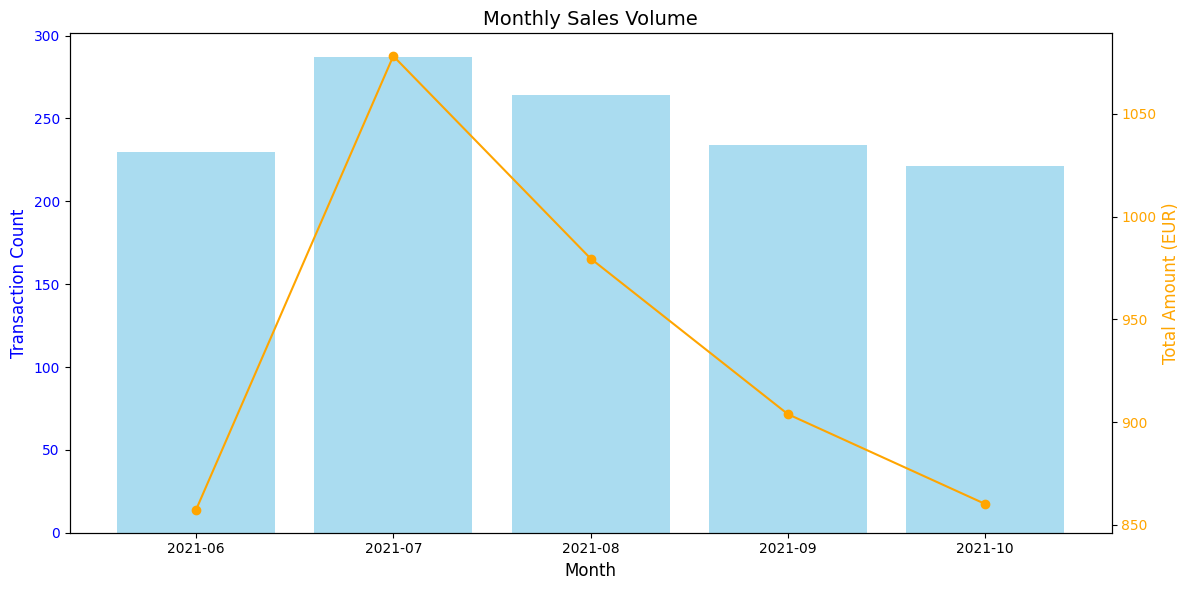

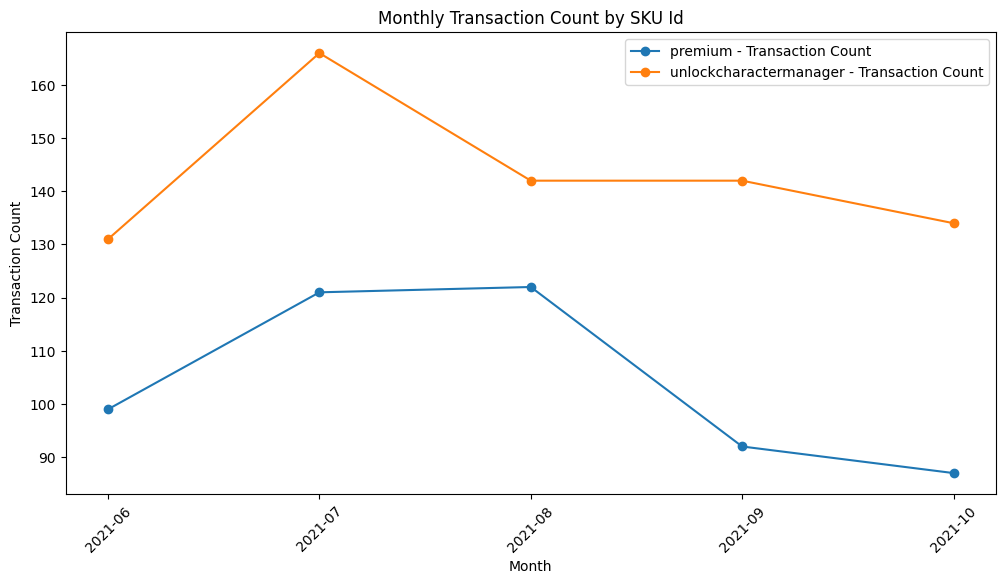

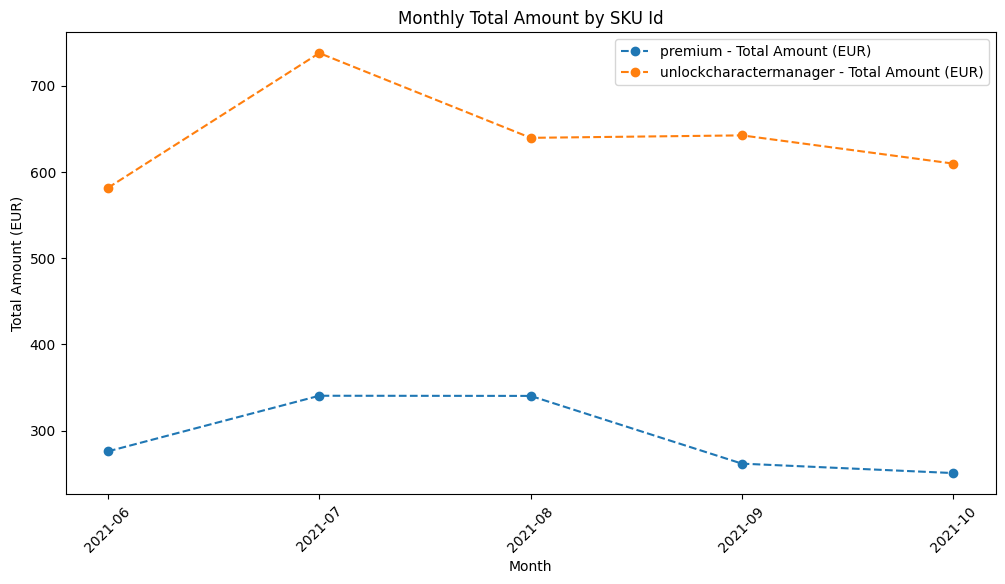

In [2]:
file_paths = glob.glob(os.path.join('Data', 'sales_*.csv'))
sales_dfs = [pd.read_csv(file) for file in file_paths]
sales_df = pd.concat(sales_dfs, ignore_index=True)
print("Combined DataFrame head:")
print(sales_df.head())
print("Number of rows:", sales_df.shape[0])
sales_df = sales_df[(sales_df['Transaction Type'] == 'Charge') &
                    (sales_df['Product id'] == 'com.vansteinengroentjes.apps.ddfive')]
print(sales_df.head())

sales_df['Transaction Date'] = pd.to_datetime(sales_df['Transaction Date'])


sales_df['Month'] = sales_df['Transaction Date'].dt.to_period('M')


monthly_sales = sales_df.groupby('Month').agg(
    transaction_count=('Transaction Date', 'count'),
    total_amount=('Amount (Merchant Currency)', 'sum')
).reset_index()


fig, ax1 = plt.subplots(figsize=(12, 6))


ax1.bar(monthly_sales['Month'].astype(str), monthly_sales['transaction_count'], color='skyblue', label='Transaction Count', alpha=0.7)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Transaction Count', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(monthly_sales['Month'].astype(str), monthly_sales['total_amount'], color='orange', marker='o', label='Total Amount (EUR)')
ax2.set_ylabel('Total Amount (EUR)', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')


plt.title('Monthly Sales Volume', fontsize=14)
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

sales_df['Transaction Date'] = pd.to_datetime(sales_df['Transaction Date'])


sales_df['Month'] = sales_df['Transaction Date'].dt.to_period('M')


sku_sales = sales_df.groupby(['Sku Id', 'Month']).agg(
    transaction_count=('Transaction Date', 'count'),
    total_amount=('Amount (Merchant Currency)', 'sum')
).reset_index()

sku_ids = sku_sales['Sku Id'].unique()

plt.figure(figsize=(12, 6))
for sku in sku_ids:
    sku_data = sku_sales[sku_sales['Sku Id'] == sku]
    plt.plot(sku_data['Month'].astype(str), sku_data['transaction_count'], marker='o', label=f'{sku} - Transaction Count')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.title('Monthly Transaction Count by SKU Id')
plt.legend()
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(12, 6))
for sku in sku_ids:
    sku_data = sku_sales[sku_sales['Sku Id'] == sku]
    plt.plot(sku_data['Month'].astype(str), sku_data['total_amount'], marker='o', linestyle='--', label=f'{sku} - Total Amount (EUR)')
plt.xlabel('Month')
plt.ylabel('Total Amount (EUR)')
plt.title('Monthly Total Amount by SKU Id')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [3]:
output_file('filename.html', title="trying stuff out")
output_notebook()

fig = figure(x_range = monthly_sales['Month'].astype(str),
             title_location='right',
             toolbar_location='below',
             tools='save')
fig.vbar(x = monthly_sales['Month'].astype(str), top=monthly_sales['transaction_count'], width=0.8)
show(fig)

Loading BokehJS ...

In [4]:
### crashes
file_paths = glob.glob(os.path.join('Data', 'stats_crashes_*.csv'))
stats_crashes_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
stats_crashes_dfs = pd.concat(stats_crashes_dfs, ignore_index=True)
print("Combined DataFrame head:")
print(stats_crashes_dfs.head())
print(stats_crashes_dfs.columns)
print(stats_crashes_dfs.size)

Combined DataFrame head:
         Date                         Package Name  Daily Crashes  Daily ANRs
0  2021-06-01  com.vansteinengroentjes.apps.ddfive             15           1
1  2021-06-02  com.vansteinengroentjes.apps.ddfive             12           1
2  2021-06-03  com.vansteinengroentjes.apps.ddfive             20           1
3  2021-06-04  com.vansteinengroentjes.apps.ddfive             13           0
4  2021-06-05  com.vansteinengroentjes.apps.ddfive             14           0
Index(['Date', 'Package Name', 'Daily Crashes', 'Daily ANRs'], dtype='object')
856


In [5]:
file_paths = glob.glob(os.path.join('Data', 'stats_ratings_*_country.csv'))
stats_ratings_country_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
stats_ratings_country_dfs = pd.concat(stats_ratings_country_dfs, ignore_index=True)
print("Combined DataFrame head:")
print(stats_ratings_country_dfs.head())
print(stats_ratings_country_dfs.columns)
print(stats_ratings_country_dfs.size)

Combined DataFrame head:
         Date                         Package Name Country  \
0  2021-06-01  com.vansteinengroentjes.apps.ddfive      AR   
1  2021-06-01  com.vansteinengroentjes.apps.ddfive      AT   
2  2021-06-01  com.vansteinengroentjes.apps.ddfive      AU   
3  2021-06-01  com.vansteinengroentjes.apps.ddfive      BA   
4  2021-06-01  com.vansteinengroentjes.apps.ddfive      BD   

   Daily Average Rating  Total Average Rating  
0                   NaN                  4.20  
1                   NaN                  3.91  
2                   NaN                  4.19  
3                   NaN                  5.00  
4                   NaN                  5.00  
Index(['Date', 'Package Name', 'Country', 'Daily Average Rating',
       'Total Average Rating'],
      dtype='object')
93085


In [6]:
file_paths = glob.glob(os.path.join('Data', 'stats_ratings_*_overview.csv'))
stats_ratings_overview_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
stats_ratings_overview_dfs = pd.concat(stats_ratings_overview_dfs, ignore_index=True)
print("Combined DataFrame head:")
print(stats_ratings_overview_dfs.head())
print(stats_ratings_overview_dfs.columns)
print(stats_ratings_overview_dfs.size)

Combined DataFrame head:
         Date                         Package Name  Daily Average Rating  \
0  2021-06-01  com.vansteinengroentjes.apps.ddfive                   5.0   
1  2021-06-02  com.vansteinengroentjes.apps.ddfive                   2.0   
2  2021-06-03  com.vansteinengroentjes.apps.ddfive                   NaN   
3  2021-06-04  com.vansteinengroentjes.apps.ddfive                   NaN   
4  2021-06-05  com.vansteinengroentjes.apps.ddfive                   NaN   

   Total Average Rating  
0                  4.15  
1                  4.15  
2                  4.15  
3                  4.15  
4                  4.15  
Index(['Date', 'Package Name', 'Daily Average Rating', 'Total Average Rating'], dtype='object')
856


In [7]:
file_paths = glob.glob(os.path.join('Data', 'reviews_*.csv'))
reviews_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
reviews_dfs = pd.concat(reviews_dfs, ignore_index=True)
print("Combined DataFrame head:")
print(reviews_dfs.head())
print(reviews_dfs.columns)
print(reviews_dfs.size)

Combined DataFrame head:
                          Package Name  App Version Code App Version Name  \
0  com.vansteinengroentjes.apps.ddfive             282.0            8.0.9   
1  com.vansteinengroentjes.apps.ddfive             282.0            8.0.9   
2  com.vansteinengroentjes.apps.ddfive               NaN              NaN   
3  com.vansteinengroentjes.apps.ddfive             282.0            8.0.9   
4  com.vansteinengroentjes.apps.ddfive             282.0            8.0.9   

  Reviewer Language        Device Review Submit Date and Time  \
0                en          flox        2021-06-01T10:28:24Z   
1                en         river        2021-06-02T16:16:24Z   
2                en        U693CL        2021-06-08T06:01:48Z   
3                en        taimen        2020-04-20T19:31:03Z   
4                de  OnePlus7TPro        2021-06-12T11:20:20Z   

   Review Submit Millis Since Epoch Review Last Update Date and Time  \
0                     1622543304307             2

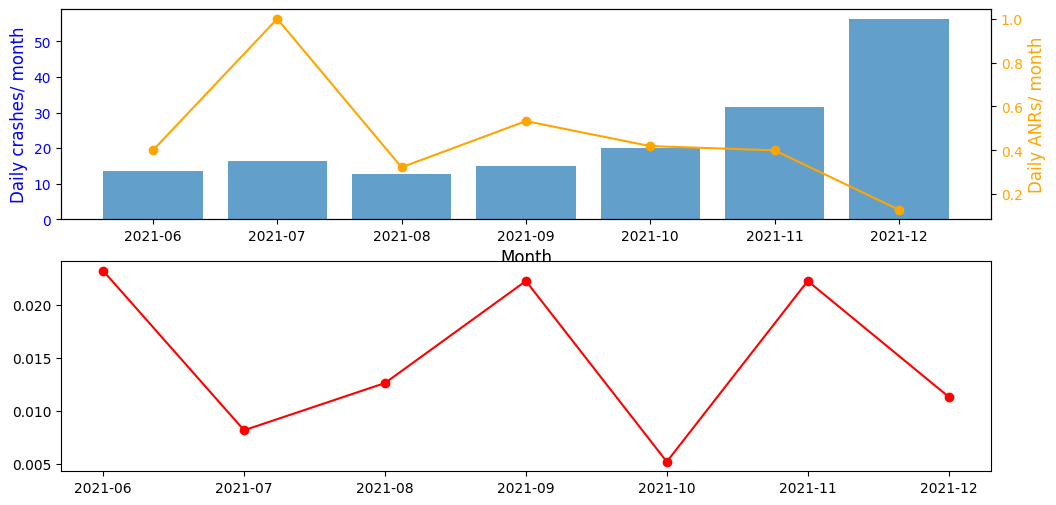

In [8]:
### ratings as a metric fuck around
### checking stats_rating_overview
# mn = np.mean(stats_ratings_overview_dfs['Daily Average Rating'])
# print(mn)
# stats_ratings_overview_dfs.fillna(mn)
### bare trash
### check country stuff
stats_ratings_country_dfs['Date'] = pd.to_datetime(stats_ratings_country_dfs['Date'])
stats_ratings_country_dfs['Month'] = stats_ratings_country_dfs['Date'].dt.to_period('M')
stats_ratings_country_dfs['Daily Average Rating'] = stats_ratings_country_dfs['Daily Average Rating'].fillna(0)
stats_ratings_country_dfs.describe()
### daily average rating
group_ratings_by_month = stats_ratings_country_dfs.groupby(['Month']).agg(
    daily_avg_per_country = ('Daily Average Rating', 'mean'),
).reset_index()
group_ratings_by_month['Daily Average Rating per Month'] = group_ratings_by_month['daily_avg_per_country'] * 100
stats_crashes_dfs['Date'] = pd.to_datetime(stats_crashes_dfs['Date'])
stats_crashes_dfs['Month'] = stats_crashes_dfs['Date'].dt.to_period('M')
group_crashes_by_month = stats_crashes_dfs.groupby(['Month']).agg(
    daily_avg_crashes = ('Daily Crashes', 'mean'),
    daily_avg_anr = ('Daily ANRs', 'mean')
).reset_index()
group_crashes_by_month

fig, (ax1, ax2)=plt.subplots(2, 1, figsize=(12, 6))

ax1.bar(group_crashes_by_month['Month'].astype(str), group_crashes_by_month['daily_avg_crashes'], label='Avg rating / Month', alpha=0.7)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Daily crashes/ month', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')


axf = ax1.twinx()
axf.plot(group_crashes_by_month['Month'].astype(str), group_crashes_by_month['daily_avg_anr'], color='orange', marker='o')
axf.set_ylabel('Daily ANRs/ month', color='orange', fontsize=12)
axf.tick_params(axis='y', labelcolor='orange')

ax2.plot(group_ratings_by_month['Month'].astype(str), group_ratings_by_month['daily_avg_per_country'], color='red', marker='o')

In [30]:
### Geographical development

### sales vol per country
### avg rating per country
group_ratings_by_country = stats_ratings_country_dfs.groupby(['Country']).agg(
    daily_avg_per_country = ('Total Average Rating', 'mean')).reset_index()

group_transactions_by_country = sales_df.groupby(['Buyer Country']).agg(
    transaction_count=('Transaction Date', 'count')
).reset_index()
print(group_ratings_by_country)
print(group_transactions_by_country)

d = {'ISO_A2': group_ratings_by_country['Country'], 'Average Rating': group_ratings_by_country['daily_avg_per_country'], 'Transaction Count':group_transactions_by_country['transaction_count']}
new_frame_ratings_transactions = pd.DataFrame(data=d)
new_frame_ratings_transactions = new_frame_ratings_transactions.fillna(0)

### world map tings yeah

   Country  daily_avg_per_country
0       AR               4.200000
1       AT               3.834112
2       AU               4.193551
3       BA               5.000000
4       BD               5.000000
..     ...                    ...
82      US               4.033458
83      UY               4.860654
84      VE               4.000000
85      VN               5.000000
86      ZA               4.349860

[87 rows x 2 columns]
   Buyer Country  transaction_count
0             AT                  3
1             AU                 21
2             BE                  2
3             BG                  1
4             BR                  3
5             CA                 55
6             CH                  2
7             CZ                  4
8             DE                 28
9             DK                  3
10            ES                  3
11            FR                  3
12            GB                 70
13            GR                  7
14            ID             

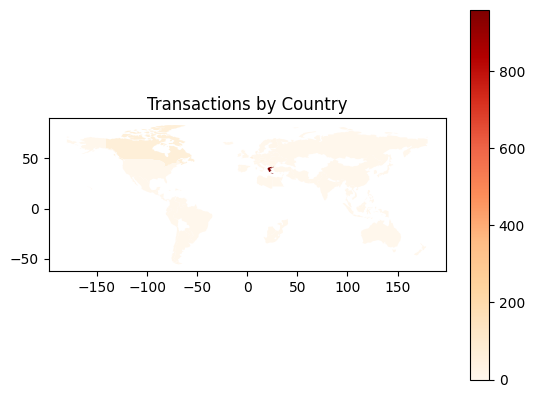

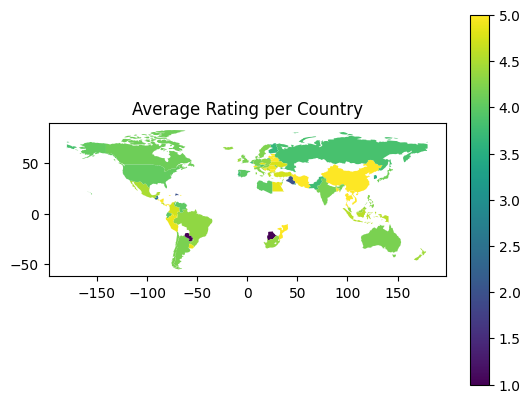

In [35]:
# map_fig = px.scatter_geo(new_frame_ratings_transactions,
#                          locations='Country', hover_data=['Average Rating', 'Transaction Count'])
# map_fig.show()

# Load world shapefile data
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)

# Merge world geometries with your data
world = gdf.merge(new_frame_ratings_transactions, how="outer", left_on="ISO_A2", right_on="ISO_A2")

# Plotting
world.plot(column='Transaction Count', cmap='OrRd', legend=True)
plt.title("Transactions by Country")
world.plot(column='Average Rating', legend=True)
plt.title("Average Rating per Country")
plt.show()